# Analysis of NBA
### Adam Malyshev

## Introduction
Sports are always a treasure trove of data. Nothing goes unnoticed and unrecorded, now more than ever in the age of the internet. Every discussion online, talk show on the air, or just a debate among friends always includes a mention of statistics.
Basketball, like other sports, has fundamentally changed due to this shift to statistic-centric strategy over the "traditional" methodology. The Golden State Warriors domination in the mid to late 2010s is an embodiment of this shift, from a more "drive into the paint" style of play to a focus on the 3 pointer. You can read more about the three point revolution [here](https://en.wikipedia.org/wiki/Three-point_revolution).
This is a simple tutorial that dives into the world of statistics in Basketball with our goal being to find the most crucial aspects of the game that contribute to a winning strategy, and in the process create a predictor of a team's wins based on their statistics.

All data we will be using will be scraped from [Basketball Reference](https://www.basketball-reference.com). It's a site dedicated to collecting highly detailed data on all things basketball, so it is a great choice for us to get started with.

## Data Acquisition

In [5]:
# imports needed
import pandas as pd

import matplotlib.pyplot as plt


import time
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
import re
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn import linear_model

/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2798307433.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


First, let's checkout the site, specfically the season summary tab and see what's on it using Selenium and Beautiful Soup.

In [6]:
# Create a new instance of the Safari driver
driver = webdriver.Safari()

# Navigate to the website
try:
    driver.get("https://www.basketball-reference.com/leagues/NBA_2023.html")
    bs = BeautifulSoup(driver.page_source, "html.parser")
finally:                
    driver.quit()

Let's get all the tables on the site.

In [7]:
tab = bs.findAll("table")
tab[:10]

[<table class="suppress_all sortable stats_table now_sortable sticky_table eq1 re1 le1" data-cols-to-freeze=",1" id="confs_standings_E">
 <caption>Conference Standings Table</caption>
 <colgroup><col/><col/><col/><col/><col/><col/><col/><col/></colgroup>
 <thead>
 <tr>
 <th aria-label="Eastern Conference" class="poptip sort_default_asc left" data-stat="team_name" scope="col">Eastern Conference</th>
 <th aria-label="Wins" class="poptip right" data-stat="wins" data-tip="Wins" scope="col">W</th>
 <th aria-label="Losses" class="poptip right" data-stat="losses" data-tip="Losses" scope="col">L</th>
 <th aria-label="Win-Loss Percentage" class="poptip right" data-stat="win_loss_pct" data-tip="Win-Loss Percentage" scope="col">W/L%</th>
 <th aria-label="GB" class="poptip sort_default_asc right" data-stat="gb" data-tip="Games Behind" scope="col">GB</th>
 <th aria-label="Points Per Game" class="poptip right" data-stat="pts_per_g" data-tip="Points Per Game" scope="col">PS/G</th>
 <th aria-label="Op

Looks like there's a lot of empty tables on the site. If we go and investigate with inspect element we can see that relevant tables have an *id* field, so let's print all the ids of tables.

In [8]:
for (idx,table) in enumerate(tab):
    id =table.get('id')
    if id:
        print(f"{idx}: {id}")

0: confs_standings_E
1: confs_standings_W
2: divs_standings_E
3: divs_standings_W
4: all_playoffs
20: per_game-team
21: per_game-opponent
22: totals-team
23: totals-opponent
24: per_poss-team
25: per_poss-opponent
26: advanced-team
27: shooting-team
28: shooting-opponent
29: all_awards


Let's checkout the *per_game-team* table as it looks to be the main table on the site with all of the most important information.

In [9]:
per_game = bs.find(name="table", id="per_game-team")

per_game_test = pd.read_html(str(per_game), header=0)
per_game_test[0].head()

/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/3086618454.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  per_game_test = pd.read_html(str(per_game), header=0)


,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Sacramento Kings*,82,241.8,43.6,88.2,.494,13.8,37.3,.369,...,.790,9.5,32.9,42.5,27.3,7.0,3.4,13.5,19.7,120.7
1,2,Golden State Warriors*,82,241.8,43.1,90.2,.479,16.6,43.2,.385,...,.794,10.5,34.1,44.6,29.8,7.2,3.9,16.3,21.4,118.9
2,3,Atlanta Hawks*,82,242.1,44.6,92.4,.483,10.8,30.5,.352,...,.818,11.2,33.2,44.4,25.0,7.1,4.9,12.9,18.8,118.4
3,4,Boston Celtics*,82,243.7,42.2,88.8,.475,16.0,42.6,.377,...,.812,9.7,35.6,45.3,26.7,6.4,5.2,13.4,18.8,117.9
4,5,Oklahoma City Thunder,82,242.1,43.1,92.6,.465,12.1,34.1,.356,...,.809,11.4,32.3,43.6,24.4,8.2,4.2,13.0,21.0,117.5


Here is a short defintion for each term in the table:

G = Games, MP = Minutes Played, FG = Field Goals, FGA = Field Goals Attempted, FG% = Field Goal Percentage, 

3P = 3-Point Field Goals, 3PA = 3-Point Field Goal Attempts, 3P% = 3-Point Field Goal Percentage,  2P = 2-Point Field Goals, 

2PA = 2-Point Field Goal Attempts, 2P% = 2-Point Field Goal Percentage, FT = Free Throws, FTA = Free Throws Attempted, 

FT% = Free Throw Percentage, ORB = Offensive Rebounds, DRB = Defensive Rebounds, TRB = Total Rebounds, 

AST = Assists, STL = Steals, BLK = Blocks, TOV = Turnovers, PF = Personal Fouls, PTS = Points

Nice, *pandas* converts it directly into a nice dataframe that just needs some minor cleaning that we will get to later. However their are no statistics on a teams performance here in terms of wins in the regular or post-season. So let's look at the playoffs table.

In [10]:
playoffs = bs.find(name="table", id="all_playoffs")
print(playoffs.find("tr").prettify())


<tr>
 <td>
  <span class="tooltip opener" data-has-listener="true" data-id="s940">
   <strong>
    Finals
   </strong>
  </span>
 </td>
 <td>
  <a href="/teams/DEN/2023.html">
   Denver Nuggets
  </a>
  over
  <a href="/teams/MIA/2023.html">
   Miami Heat
  </a>
  (4-1)
 </td>
 <td>
  <a href="/playoffs/2023-nba-finals-heat-vs-nuggets.html">
   Series Stats
  </a>
 </td>
</tr>



In [327]:
playoffs_test = pd.read_html(str(playoffs), header=0)
playoffs_test[0].head()

/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_32864/2606354623.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  playoffs_test = pd.read_html(str(playoffs), header=0)


,Finals,Denver Nuggets over Miami Heat (4-1),Series Stats,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"Game 1 Thu, June 1 Miami Heat 93@ Denver Nugge...","Game 1 Thu, June 1 Miami Heat 93@ Denver Nugge...","Game 1 Thu, June 1 Miami Heat 93@ Denver Nugge...",NaN,NaN,NaN
1,Game 1,"Thu, June 1",Miami Heat,93.0,@ Denver Nuggets,104.0
2,Game 2,"Sun, June 4",Miami Heat,111.0,@ Denver Nuggets,108.0
3,Game 3,"Wed, June 7",Denver Nuggets,109.0,@ Miami Heat,94.0
4,Game 4,"Fri, June 9",Denver Nuggets,108.0,@ Miami Heat,95.0


It's not in such a nice format as the previous table, so we need to extract some data from it manually.

In [21]:
playoff_rows = playoffs.findAll({"tr"})
playoff_rows[:2]

[<tr>
 <td><span class="tooltip opener" data-has-listener="true" data-id="s940"><strong>Finals</strong></span></td>
 <td><a href="/teams/DEN/2023.html">Denver Nuggets</a> 
 over 
 <a href="/teams/MIA/2023.html">Miami Heat</a>
  (4-1)
 </td>
 <td><a href="/playoffs/2023-nba-finals-heat-vs-nuggets.html">Series Stats</a></td>
 </tr>,
 <tr class="toggleable" id="s940">
 <td colspan="3"><div>
 <table>
 <tbody><tr>
 <td><a href="/boxscores/202306010DEN.html">Game 1</a></td>
 <td>Thu, June 1</td>
 <td>Miami Heat</td>
 <td>93</td><td>@ Denver Nuggets</td>
 <td>104</td></tr>
 <tr>
 <td><a href="/boxscores/202306040DEN.html">Game 2</a></td>
 <td>Sun, June 4</td>
 <td>Miami Heat</td>
 <td>111</td><td>@ Denver Nuggets</td>
 <td>108</td></tr>
 <tr>
 <td><a href="/boxscores/202306070MIA.html">Game 3</a></td>
 <td>Wed, June 7</td>
 <td>Denver Nuggets</td>
 <td>109</td><td>@ Miami Heat</td>
 <td>94</td></tr>
 <tr>
 <td><a href="/boxscores/202306090MIA.html">Game 4</a></td>
 <td>Fri, June 9</td>
 <td>D

As you can see some of the rows in the table are empty and some columns have the playoff series results while some have game information. We just want the results. Note that they are in the format *Team1 over Team2 (Score)*. We can then create a regex that will find the rows that only have that information and extract it with groups.

In [22]:
# for all rows
for row in playoff_rows:
    # find all the columns in the row
    columns= row.findAll({"td"})
    # look at only non degenerate rows
    if (len(columns) >= 2):
        #  get text
        txt=columns[1].get_text()
        # apply regex
        match = re.search(r"^\s*([a-zA-Z ]+)\s*over\s*([a-zA-Z ]+)\s*\((\d)-(\d)\)\s*$", txt) 
        # if matches extract the groups
        if (match):
            print(f"{match.group(1)} {match.group(2)} {match.group(3)} {match.group(4)}")

Denver Nuggets  Miami Heat 4 1
Miami Heat  Boston Celtics 4 3
Denver Nuggets  Los Angeles Lakers 4 0
Miami Heat  New York Knicks 4 2
Denver Nuggets  Phoenix Suns 4 2
Los Angeles Lakers  Golden State Warriors 4 2
Boston Celtics  Atlanta Hawks 4 2
Miami Heat  Milwaukee Bucks 4 1
New York Knicks  Cleveland Cavaliers 4 1
Denver Nuggets  Minnesota Timberwolves 4 1
Golden State Warriors  Sacramento Kings 4 3
Los Angeles Lakers  Memphis Grizzlies 4 2
Phoenix Suns  Los Angeles Clippers 4 1


Now let's create a function that extracts that for us given the beautiful soup object.

In [35]:
def get_playoff_stats(playoff_table_bs):
    # create dict that stores the teams and corresponding play off wins
    data = {'Team':[], 'playoff_wins':[]}
    # find all the rows
    playoff_rows = playoff_table_bs.findAll({"tr"})
    
    for row in playoff_rows:
        # find columns for all the rows
        columns= row.findAll({"td"})
        # look at non-degenerate rows
        if (len(columns) >= 2):
            # extract
            txt=columns[1].get_text()
            match = re.search(r"^\s*([a-zA-Z ]+)\s*over\s*([a-zA-Z ]+)\s*\((\d)-(\d)\)\s*$", txt) 
            # add team names and their playoff wins into the dictionary, stripping white space off
            if (match):
               data['Team'].append(str(match.group(1)).strip())
               data['playoff_wins'].append(int(match.group(3)))
               data['Team'].append(str(match.group(2)).strip())
               data['playoff_wins'].append(int(match.group(4)))
    # create a dataframe
    df = pd.DataFrame(data=data)
    # add all the playoff wins by team
    df = df.groupby(["Team"]).sum()
    df = df.reset_index()
    return df
    

In [36]:
get_playoff_stats(playoffs)

,Team,playoff_wins
0,Atlanta Hawks,2
1,Boston Celtics,7
2,Cleveland Cavaliers,1
3,Denver Nuggets,16
4,Golden State Warriors,6
5,Los Angeles Clippers,1
6,Los Angeles Lakers,8
7,Memphis Grizzlies,2
8,Miami Heat,13
9,Milwaukee Bucks,1


Now let's move to the wins in the regular season. If we look back to the table ids there are conference standings and division standings. Turns out some of the older seasons don't have the conference standings table, so we will use the division standings table, which contains the same information.

In [25]:
east_div_standings = bs.find(name="table", id="divs_standings_E")
print(east_div_standings.find_all("tr")[2].prettify())

<tr class="full_table" data-row="1">
 <th class="left" data-stat="team_name" scope="row">
  <a href="/teams/BOS/2023.html">
   Boston Celtics
  </a>
  *
 </th>
 <td class="right" data-stat="wins">
  57
 </td>
 <td class="right" data-stat="losses">
  25
 </td>
 <td class="right" data-stat="win_loss_pct">
  .695
 </td>
 <td class="right" data-stat="gb">
  —
 </td>
 <td class="right" data-stat="pts_per_g">
  117.9
 </td>
 <td class="right" data-stat="opp_pts_per_g">
  111.4
 </td>
 <td class="right" data-stat="srs">
  6.38
 </td>
</tr>



Looks pretty good so let's try handing it off to pandas.

In [26]:
edivdf = pd.read_html(str(east_div_standings), header=0)[0]
edivdf.head(5)

/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2674572810.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  edivdf = pd.read_html(str(east_div_standings), header=0)[0]


,Eastern Conference,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division
1,Boston Celtics*,57,25,.695,—,117.9,111.4,6.38
2,Philadelphia 76ers*,54,28,.659,3.0,115.2,110.9,4.37
3,New York Knicks*,47,35,.573,10.0,116.0,113.1,2.99
4,Brooklyn Nets*,45,37,.549,12.0,113.4,112.5,1.03


Great now rename the *Eastern Conference* column to Team to match the rest of our tables.

In [27]:
edivdf.columns = ["Team", "W", "L", "W/L%", "GB", "PS/G", "PA/G", "SRS"]
edivdf.head(5)

,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division
1,Boston Celtics*,57,25,.695,—,117.9,111.4,6.38
2,Philadelphia 76ers*,54,28,.659,3.0,115.2,110.9,4.37
3,New York Knicks*,47,35,.573,10.0,116.0,113.1,2.99
4,Brooklyn Nets*,45,37,.549,12.0,113.4,112.5,1.03


Now we repeat the same for the west.

In [29]:
west_div_standings = bs.find(name="table", id="divs_standings_W")
wdivdf = pd.read_html(str(west_div_standings), header=0)[0]
wdivdf.columns = ["Team", "W", "L", "W/L%", "GB", "PS/G", "PA/G", "SRS"]
wdivdf.head(5)

/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2424840981.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  wdivdf = pd.read_html(str(west_div_standings), header=0)[0]


,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Northwest Division,Northwest Division,Northwest Division,Northwest Division,Northwest Division,Northwest Division,Northwest Division,Northwest Division
1,Denver Nuggets*,53,29,.646,—,115.8,112.5,3.04
2,Minnesota Timberwolves*,42,40,.512,11.0,115.8,115.8,-0.22
3,Oklahoma City Thunder,40,42,.488,13.0,117.5,116.4,0.96
4,Utah Jazz,37,45,.451,16.0,117.1,118.0,-1.03


Now we need to combine them on their columns, so do a concat on axis 0.

In [30]:
standings = pd.concat([edivdf,wdivdf], axis=0)

In [31]:
standings.head(5)

,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division
1,Boston Celtics*,57,25,.695,—,117.9,111.4,6.38
2,Philadelphia 76ers*,54,28,.659,3.0,115.2,110.9,4.37
3,New York Knicks*,47,35,.573,10.0,116.0,113.1,2.99
4,Brooklyn Nets*,45,37,.549,12.0,113.4,112.5,1.03


Teams that were in the playoffs are marked with an astrick so we can create a new boolean column that is true if the value in team has an asterick.

In [32]:
standings["in_playoffs"] = standings["Team"].str.contains("*", regex=False)
standings.head()

,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs
0,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,False
1,Boston Celtics*,57,25,.695,—,117.9,111.4,6.38,True
2,Philadelphia 76ers*,54,28,.659,3.0,115.2,110.9,4.37,True
3,New York Knicks*,47,35,.573,10.0,116.0,113.1,2.99,True
4,Brooklyn Nets*,45,37,.549,12.0,113.4,112.5,1.03,True


Now remove the astrerick.

In [339]:

standings["Team"] = standings["Team"].str.replace("*","")
standings.head(5)

,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs
0,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,Atlantic Division,False
1,Boston Celtics,57,25,.695,—,117.9,111.4,6.38,True
2,Philadelphia 76ers,54,28,.659,3.0,115.2,110.9,4.37,True
3,New York Knicks,47,35,.573,10.0,116.0,113.1,2.99,True
4,Brooklyn Nets,45,37,.549,12.0,113.4,112.5,1.03,True


Remove the division names from the table to clean it up.

In [340]:
standings= standings[~standings['Team'].str.contains("Division", regex=False)]
standings.head()

,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs
1,Boston Celtics,57,25,.695,—,117.9,111.4,6.38,True
2,Philadelphia 76ers,54,28,.659,3.0,115.2,110.9,4.37,True
3,New York Knicks,47,35,.573,10.0,116.0,113.1,2.99,True
4,Brooklyn Nets,45,37,.549,12.0,113.4,112.5,1.03,True
5,Toronto Raptors,41,41,.500,16.0,112.9,111.4,1.59,False


Now let's make a function that combines our previous steps and compiles all of the data we want from a given season.

In [40]:


# function to extract the season info in "year" 
# and append to "dataframe"
def get_season_table_stats(year):
    table_id="per_game-team"
    # Navigate to basketball reference 
    try:
        # get season season summary page from basketball reference
        driver = webdriver.Safari()
        driver.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")
        # load into Beautiful Soup object to scrape
        bs = BeautifulSoup(driver.page_source, "html.parser")
    finally:
        driver.quit()
    # sleep to throttle API calls
    time.sleep(1)
    
    # find table with the exact id we want "table_id"
    table=bs.find(name="table", id=table_id)
    # create into pandas dataframe
    new_table = pd.read_html(str(table), header=0)[0]
    
    # same as above
    playoffs = get_playoff_stats(bs.find(name="table", id="all_playoffs"))
    
    east_div_standings = bs.find(name="table", id="divs_standings_E")
    edivdf = pd.read_html(str(east_div_standings), header=0)[0]
    edivdf.columns = ["Team", "W", "L", "W/L%", "GB", "PS/G", "PA/G", "SRS"]

    west_div_standings = bs.find(name="table", id="divs_standings_W")
    wdivdf = pd.read_html(str(west_div_standings), header=0)[0]
    wdivdf.columns = ["Team", "W", "L", "W/L%", "GB", "PS/G", "PA/G", "SRS"]

    standdf = pd.concat([edivdf,wdivdf], axis=0)
    standdf= standdf[~standdf['Team'].str.contains("Division", regex=False)]

    new_table = new_table.join(standdf.set_index('Team'), on="Team")

    new_table['in_playoffs'] = new_table['Team'].str.contains('*', regex=False)
    
    new_table["Team"] = new_table["Team"].str.replace("*","")
    joined = new_table.join(playoffs.set_index('Team'), on="Team")

    # add a year column
    joined['year'] = [year]*joined.shape[0]
    joined.fillna(0,inplace=True)

    
    return(joined)

Test it out on 1990

In [42]:
table1990 = get_season_table_stats(1990)

/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2518945315.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  new_table = pd.read_html(str(table), header=0)[0]
/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2518945315.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  edivdf = pd.read_html(str(east_div_standings), header=0)[0]
/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2518945315.py:30: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  wdivdf = pd.read_html(str(west_div_standings), header=0)[0]


In [43]:
print(table1990)

      Rk                    Team   G     MP    FG   FGA    FG%   3P   3PA  \
0    1.0   Golden State Warriors  82  240.3  42.5  87.9  0.484  3.0   9.1   
1    2.0            Phoenix Suns  82  242.1  43.2  87.1  0.496  2.1   6.6   
2    3.0          Denver Nuggets  82  241.5  45.3  97.7  0.464  2.8   8.3   
3    4.0  Portland Trail Blazers  82  242.4  43.6  92.0  0.473  2.3   6.9   
4    5.0           Orlando Magic  82  241.5  42.2  91.8  0.459  1.4   4.8   
5    6.0      Los Angeles Lakers  82  242.1  41.9  85.5  0.490  3.8  10.3   
6    7.0      Philadelphia 76ers  82  241.5  41.9  85.7  0.489  2.3   6.6   
7    8.0          Boston Celtics  82  240.3  43.5  87.2  0.498  1.3   4.9   
8    9.0           Chicago Bulls  82  241.8  43.1  86.5  0.498  3.0   8.2   
9   10.0          Indiana Pacers  82  242.4  41.2  83.0  0.497  3.6   9.4   
10  11.0           Atlanta Hawks  82  240.6  41.7  85.6  0.487  1.5   5.0   
11  12.0         New York Knicks  82  241.8  41.9  86.5  0.484  2.9   8.7   

Works, now let's create a new dataframe and concat to it 32 seasons of data. From 1990 to 2023.

In [44]:
# create main dataframe with all data
main_df = pd.DataFrame()

In [45]:
years=[]

In [47]:

for year in range(1991, 2023):
    table = get_season_table_stats(year)
    years.append(table)

/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2518945315.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  new_table = pd.read_html(str(table), header=0)[0]
/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2518945315.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  edivdf = pd.read_html(str(east_div_standings), header=0)[0]
/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2518945315.py:30: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  wdivdf = pd.read_html(str(west_div_standings), header=0)[0]
/var/folders/dj/gv0qj_cd5yx769z2qvzd8vw80000gn/T/ipykernel_818/2518945315.

In [48]:
len(years)

32

In [49]:
main_df = pd.concat(years, axis=0)

In [50]:
main_df.head(10)

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs,playoff_wins,year
0,1.0,Denver Nuggets,82,240.6,47.6,108.1,0.44,3.7,12.9,0.283,...,20,62,.244,35.0,119.9,130.8,-10.31,False,0.0,1991
1,2.0,Golden State Warriors,82,241.5,43.5,89.6,0.485,3.3,9.8,0.337,...,44,38,.537,19.0,116.6,115.0,1.72,True,4.0,1991
2,3.0,Portland Trail Blazers,82,242.7,43.6,89.9,0.485,4.2,11.0,0.377,...,63,19,.768,—,114.7,106.0,8.47,True,9.0,1991
3,4.0,Phoenix Suns,82,240.6,43.6,87.8,0.496,1.7,5.3,0.319,...,55,27,.671,8.0,114.0,107.5,6.49,True,1.0,1991
4,5.0,Indiana Pacers,82,241.5,42.1,85.3,0.493,3.0,9.1,0.332,...,41,41,.500,20.0,111.7,112.1,-0.37,True,2.0,1991
5,6.0,Boston Celtics,82,241.5,45.1,88.0,0.512,1.3,4.2,0.315,...,56,26,.683,—,111.5,105.7,5.22,True,5.0,1991
6,7.0,Chicago Bulls,82,240.9,44.3,86.9,0.51,1.9,5.2,0.366,...,61,21,.744,—,110.0,101.0,8.57,True,11.0,1991
7,8.0,Atlanta Hawks,82,240.9,40.8,88.1,0.464,3.3,10.2,0.324,...,43,39,.524,18.0,109.8,109.0,0.72,True,2.0,1991
8,9.0,San Antonio Spurs,82,241.8,41.6,85.2,0.488,1.0,3.6,0.273,...,55,27,.671,—,107.1,102.6,4.30,True,1.0,1991
9,10.0,Houston Rockets,82,242.1,41.5,88.9,0.467,3.9,12.1,0.32,...,52,30,.634,3.0,106.7,103.2,3.27,True,0.0,1991


### Cleaning

We need to make our dataframe work with numpy, so we need to convert it from a string to a numerical dataframe.

In [51]:
main_df.dtypes

Rk               object
Team             object
G                object
MP               object
FG               object
FGA              object
FG%              object
3P               object
3PA              object
3P%              object
2P               object
2PA              object
2P%              object
FT               object
FTA              object
FT%              object
ORB              object
DRB              object
TRB              object
AST              object
STL              object
BLK              object
TOV              object
PF               object
PTS              object
W                object
L                object
W/L%             object
GB               object
PS/G             object
PA/G             object
SRS              object
in_playoffs        bool
playoff_wins    float64
year              int64
dtype: object

In [58]:
print(main_df.iloc[6,6:].to_string())

FG%              0.51
3P                1.9
3PA               5.2
3P%             0.366
2P               42.4
2PA              81.7
2P%             0.519
FT               19.6
FTA              25.7
FT%              0.76
ORB              14.0
DRB              28.6
TRB              42.6
AST              27.0
STL              10.0
BLK               5.3
TOV              14.4
PF               21.4
PTS             110.0
W                  61
L                  21
W/L%             .744
GB                  —
PS/G            110.0
PA/G            101.0
SRS              8.57
in_playoffs      True
playoff_wins     11.0
year             1991


We found the culprit. In the statistic *GB = Games Behind* the leader in wins has a - in place of a value. This makes it a string column so let's replace it with a 0 which will not change the meaning.

In [351]:
years[20][12:17]

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs,playoff_wins,year
12,13,Indiana Pacers,82,241.2,36.6,82.8,.442,7.1,20.2,.354,...,37,45,.451,25.0,99.8,100.9,-1.38,True,1.0,2011
13,14,Utah Jazz,82,242.4,37.4,80.4,.465,5.3,15.3,.346,...,39,43,.476,16.0,99.4,101.3,-1.44,False,0.0,2011
14,15,Sacramento Kings,82,242.1,38.2,85.1,.449,5.2,15.6,.335,...,24,58,.293,33.0,99.4,104.7,-4.80,False,0.0,2011
15,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,0,0,0,0,0,0,0,False,0.0,2011
16,16,Orlando Magic,82,241.8,36.0,78.2,.461,9.4,25.6,.366,...,52,30,.634,6.0,99.2,93.7,4.92,True,2.0,2011


The column labels also got appended into the main dataframe, which makes every column a string column, so let's delete all of them, Note that the value in the Team column would be Team in every case.

In [352]:
years[20][25:]

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs,playoff_wins,year
25,25,Cleveland Cavaliers,82,240.9,35.2,81.1,.434,6.2,18.2,.342,...,19,63,.232,43.0,95.5,104.5,-8.88,False,0.0,2011
26,26,Atlanta Hawks,82,240.6,36.2,78.4,.462,6.1,17.4,.352,...,44,38,.537,14.0,95.0,95.8,-1.10,True,6.0,2011
27,27,New Orleans Hornets,82,241.8,35.9,78.2,.459,5.4,15.0,.360,...,46,36,.561,15.0,94.9,94.0,1.28,True,2.0,2011
28,28,New Jersey Nets,82,244.0,35.6,81.0,.440,5.6,16.3,.343,...,24,58,.293,32.0,94.2,100.4,-6.28,False,0.0,2011
29,29,Charlotte Bobcats,82,241.5,35.0,77.6,.451,4.8,14.7,.327,...,34,48,.415,24.0,93.3,97.3,-4.08,False,0.0,2011
30,30,Milwaukee Bucks,82,241.8,34.3,79.8,.430,5.9,17.2,.342,...,35,47,.427,27.0,91.9,92.7,-1.02,False,0.0,2011
31,0,League Average,82,241.9,37.2,81.2,.459,6.5,18.0,.358,...,0,0,0,0,0,0,0,False,0.0,2011


And the league average is also included, we don't need that so we can discard it.

In [61]:
# get rid of column labels in main_df rows
main_df= main_df[main_df['Team'] != 'Team']
# get rid of the league average rows
main_df=main_df[main_df['Team'] != 'League Average']

In [60]:
main_df["GB"].head()

0    35.0
1    19.0
2       0
3     8.0
4    20.0
Name: GB, dtype: object

In [59]:
# replace all the - in the Games behind column with 0
main_df["GB"] = main_df["GB"].str.replace("—", "0", regex=False)
main_df.head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs,playoff_wins,year
0,1.0,Denver Nuggets,82,240.6,47.6,108.1,0.44,3.7,12.9,0.283,...,20,62,.244,35.0,119.9,130.8,-10.31,False,0.0,1991
1,2.0,Golden State Warriors,82,241.5,43.5,89.6,0.485,3.3,9.8,0.337,...,44,38,.537,19.0,116.6,115.0,1.72,True,4.0,1991
2,3.0,Portland Trail Blazers,82,242.7,43.6,89.9,0.485,4.2,11.0,0.377,...,63,19,.768,0,114.7,106.0,8.47,True,9.0,1991
3,4.0,Phoenix Suns,82,240.6,43.6,87.8,0.496,1.7,5.3,0.319,...,55,27,.671,8.0,114.0,107.5,6.49,True,1.0,1991
4,5.0,Indiana Pacers,82,241.5,42.1,85.3,0.493,3.0,9.1,0.332,...,41,41,.500,20.0,111.7,112.1,-0.37,True,2.0,1991


Now we have a clean dataframe we can then safely convert to appropriate types.

In [81]:
for column in main_df.columns:
    if column in ["G", "Rk", "playoff_wins"]:
        main_df[column] = main_df[column].astype('int32')
    elif column != "Team":
        main_df[column] = main_df[column].astype('float64')


In [62]:
main_df.head(5)

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs,playoff_wins,year
0,1.0,Denver Nuggets,82,240.6,47.6,108.1,0.44,3.7,12.9,0.283,...,20,62,.244,35.0,119.9,130.8,-10.31,False,0.0,1991
1,2.0,Golden State Warriors,82,241.5,43.5,89.6,0.485,3.3,9.8,0.337,...,44,38,.537,19.0,116.6,115.0,1.72,True,4.0,1991
2,3.0,Portland Trail Blazers,82,242.7,43.6,89.9,0.485,4.2,11.0,0.377,...,63,19,.768,0,114.7,106.0,8.47,True,9.0,1991
3,4.0,Phoenix Suns,82,240.6,43.6,87.8,0.496,1.7,5.3,0.319,...,55,27,.671,8.0,114.0,107.5,6.49,True,1.0,1991
4,5.0,Indiana Pacers,82,241.5,42.1,85.3,0.493,3.0,9.1,0.332,...,41,41,.500,20.0,111.7,112.1,-0.37,True,2.0,1991


Now drop unneccessary columns.

In [66]:
main_df = main_df.drop(["Rk", "G", "MP"], axis=1)

## Exploratory Data Analysis and Visuzalition

Let's add each column into a dictionary so we can plot it more easily later.

In [67]:
column_stats={}
for column in main_df.columns:
    column_stats[column] = np.array(main_df[column])

In [68]:
column_stats['PTS'][:20]

array([119.9, 116.6, 114.7, 114.0, 111.7, 111.5, 110.0, 109.8, 107.1,
       106.7, 106.6, 106.4, 106.3, 105.9, 105.4, 104.0, 103.5, 103.1,
       102.9, 102.8], dtype=object)

In [69]:
main_df.columns

Index(['Team', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS',
       'in_playoffs', 'playoff_wins', 'year'],
      dtype='object')

Let's plot each common statistic against wins.

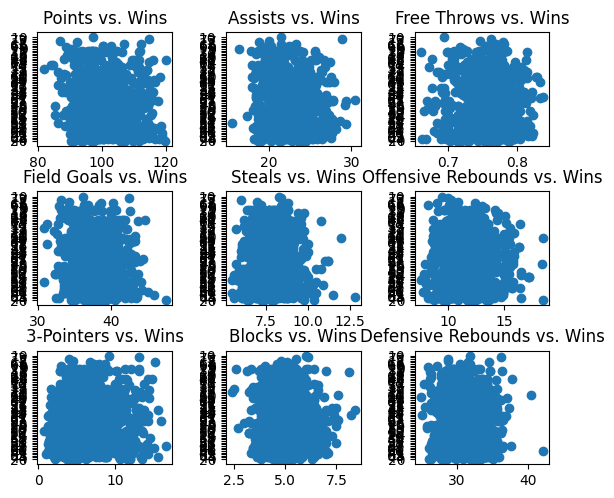

In [85]:
fig, axs = plt.subplots(3,3)
axs[0,0].scatter(x=column_stats["PTS"], y=column_stats["W"])
axs[0,0].set_title("Points vs. Wins")

axs[1,0].scatter(x=column_stats["FG"], y=column_stats["W"])
axs[1,0].set_title("Field Goals vs. Wins")

axs[2,0].scatter(x=column_stats["3P"], y=column_stats["W"])
axs[2,0].set_title("3-Pointers vs. Wins")

axs[0,1].scatter(x=column_stats["AST"], y=column_stats["W"])
axs[0,1].set_title("Assists vs. Wins")

axs[1,1].scatter(x=column_stats["STL"], y=column_stats["W"])
axs[1,1].set_title("Steals vs. Wins")

axs[2,1].scatter(x=column_stats["BLK"], y=column_stats["W"])
axs[2,1].set_title("Blocks vs. Wins")


axs[0,2].scatter(x=column_stats["FT%"], y=column_stats["W"])
axs[0,2].set_title("Free Throws vs. Wins")

axs[1,2].scatter(x=column_stats["ORB"], y=column_stats["W"])
axs[1,2].set_title("Offensive Rebounds vs. Wins")

axs[2,2].scatter(x=column_stats["DRB"], y=column_stats["W"])
axs[2,2].set_title("Defensive Rebounds vs. Wins")


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)

It's to many points to see clearly so let's groupy by each team, to see the average of each statistic and wins with respect to teams over all years.

In [88]:
by_team = main_df.groupby('Team').agg('mean')

In [87]:
by_team.head()

,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,...,W,L,W/L%,GB,PS/G,PA/G,SRS,in_playoffs,playoff_wins,year
Team,,,,,,,,,,,,,,,,,,,,,
Atlanta Hawks,37.393750,82.653125,0.452094,6.850000,19.428125,0.347875,30.550000,63.23125,0.484719,18.368750,...,38.59375,41.12500,0.485719,15.343750,99.993750,100.765625,-0.902500,0.6250,2.0000,2006.5
Boston Celtics,38.053125,83.071875,0.458094,6.928125,19.493750,0.349875,31.134375,63.56875,0.490312,18.309375,...,42.06250,37.78125,0.525875,10.734375,101.346875,100.221875,0.872812,0.6875,3.8125,2006.5
Brooklyn Nets,38.900000,85.280000,0.456400,10.440000,29.260000,0.355200,28.480000,56.02000,0.509700,17.750000,...,36.90000,43.10000,0.464100,16.100000,105.990000,107.510000,-1.734000,0.7000,1.7000,2017.5
Charlotte Bobcats,35.320000,80.270000,0.440300,5.360000,15.500000,0.344600,29.950000,64.77000,0.463500,18.450000,...,29.30000,51.10000,0.359400,25.600000,94.470000,98.980000,-4.663000,0.2000,0.0000,2009.5
Charlotte Hornets,38.195000,83.800000,0.455750,7.030000,19.480000,0.357550,31.165000,64.31000,0.485550,19.245000,...,39.70000,39.35000,0.500800,13.550000,102.700000,103.035000,-0.383000,0.4000,1.1000,2005.3


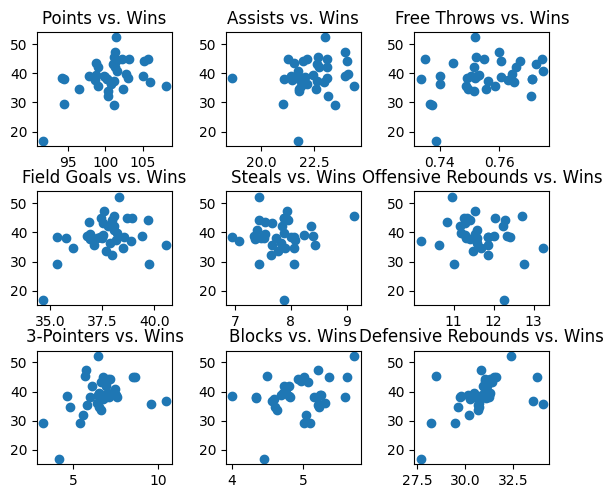

In [90]:
# plot same as before
fig, axs = plt.subplots(3,3)
axs[0,0].scatter(x=by_team["PTS"].to_numpy(), y=by_team["W"].to_numpy())
axs[0,0].set_title("Points vs. Wins")

axs[1,0].scatter(x=by_team["FG"].to_numpy(), y=by_team["W"].to_numpy())
axs[1,0].set_title("Field Goals vs. Wins")

axs[2,0].scatter(x=by_team["3P"].to_numpy(), y=by_team["W"].to_numpy())
axs[2,0].set_title("3-Pointers vs. Wins")


axs[0,1].scatter(x=by_team["AST"].to_numpy(), y=by_team["W"].to_numpy())
axs[0,1].set_title("Assists vs. Wins")

axs[1,1].scatter(x=by_team["STL"].to_numpy(), y=by_team["W"].to_numpy())
axs[1,1].set_title("Steals vs. Wins")

axs[2,1].scatter(x=by_team["BLK"].to_numpy(), y=by_team["W"].to_numpy())
axs[2,1].set_title("Blocks vs. Wins")


axs[0,2].scatter(x=by_team["FT%"].to_numpy(), y=by_team["W"].to_numpy())
axs[0,2].set_title("Free Throws vs. Wins")

axs[1,2].scatter(x=by_team["ORB"].to_numpy(), y=by_team["W"].to_numpy())
axs[1,2].set_title("Offensive Rebounds vs. Wins")

axs[2,2].scatter(x=by_team["DRB"].to_numpy(), y=by_team["W"].to_numpy())
axs[2,2].set_title("Defensive Rebounds vs. Wins")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)

For this graph it is more clear. For each statistic it seems to have a positive correlation to winning, but some have a stronger correlation than others such as Defensive rebounds over assists. Let's do an Ordinary Least Squares solution with all of the relevant statistics (from the team per game table) as features, and have the wins of each team in each season to be the wins they achieved that year. 

In [91]:
# create X and y
X = main_df[["FG","FGA","FG%","3P","3PA","3P%","2P","2PA","2P%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV"]].copy()
y= main_df["W"]
# add a constant term to X, just a column of 1s
X = sm.add_constant(X)

In [92]:
# fit an OLS model
model = sm.OLS(y, X).fit()

In [93]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     164.8
Date:                Fri, 17 May 2024   Prob (F-statistic):          1.18e-279
Time:                        20:48:44   Log-Likelihood:                -3022.0
No. Observations:                 936   AIC:                             6084.
Df Residuals:                     916   BIC:                             6181.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -170.7862    108.070     -1.580      0.1

Considering a significance level of $$\alpha=0.05$$ if we look at the variables that have a p-value less than 0.05 they are, *FG% = Field Goal Percentage%*, *2P% = Two Point Percentage*, *AST = Assists*, *STL = Steals*, and *TOV = Turnovers*. This means that these statistics contribute to more of the variance in the dataset than other statistics, so they encapsulate more information and are therefore better to regress on.
These make sense as these stats encapsulate the efficiency of teams and the effectiveness of defense. The model over all has a pretty high *R^2* value of 0.774. However it is odd that these are picked over *PTS* and *3P* for example, this might be because there is high colinearity among terms, which makes sense because there are multiple statistics measuring scoring such as *PTS*, *3P*, and *2P*.

Let's mean center the data to do a PCA to investgate the colinearity of some of our parameters.

In [95]:
# X = main_df[["FG","FGA","FG%","3P","3PA","3P%","2P","2PA","2P%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV"]].copy()
Xn = X.copy()
Xn

,const,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV
0,1.0,47.6,108.1,0.440,3.7,12.9,0.283,43.9,95.2,0.461,21.0,27.6,0.763,18.5,30.9,49.4,24.5,10.4,5.0,16.2
1,1.0,43.5,89.6,0.485,3.3,9.8,0.337,40.2,79.8,0.504,26.4,33.7,0.783,13.6,28.1,41.7,23.8,9.8,4.6,16.6
2,1.0,43.6,89.9,0.485,4.2,11.0,0.377,39.5,78.8,0.501,23.3,31.0,0.753,14.7,31.2,45.9,27.5,8.8,5.0,16.0
3,1.0,43.6,87.8,0.496,1.7,5.3,0.319,41.9,82.5,0.508,25.2,32.7,0.770,13.8,31.7,45.5,26.9,8.4,6.5,15.9
4,1.0,42.1,85.3,0.493,3.0,9.1,0.332,39.0,76.2,0.513,24.5,30.2,0.811,12.4,29.0,41.4,26.6,8.0,4.4,16.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,1.0,37.7,86.2,0.437,13.2,36.9,0.357,24.5,49.3,0.497,18.0,24.1,0.744,11.5,34.6,46.1,21.9,7.0,4.9,13.3
27,1.0,38.5,87.1,0.442,12.7,36.8,0.346,25.8,50.3,0.513,16.4,21.6,0.760,10.4,32.5,42.9,22.9,8.0,4.5,14.5
28,1.0,38.2,88.6,0.431,11.3,34.6,0.326,26.9,54.0,0.498,17.2,22.0,0.782,11.0,32.0,43.0,23.5,7.7,4.8,14.2
29,1.0,38.3,88.3,0.434,12.2,36.9,0.331,26.1,51.4,0.507,15.5,19.7,0.787,9.1,35.2,44.3,23.7,6.8,4.5,14.5


To create the covariance matrix we need to normalize X, let's use the z-score, where i is a row and j is a column:
$$z-score = \frac{x_{ij} - \mu_j}{\sigma_j},    \mu = mean,  \sigma = std. dev.$$
Where Let's do this with pandas vectorized arithmetic.

In [96]:
# for every columns, subtract from all its elements the mean of the column and divide that by the std dev. of the column
for column in Xn.columns:
    Xn[column] = (Xn[column] - np.mean(Xn[column].to_numpy()))/np.std(Xn[column].to_numpy())
# drop the constant term we don't need it
Xn = Xn.drop(["const"], axis=1)
Xn.head()


,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV
0,3.813616,6.055315,-0.900556,-0.985352,-0.727583,-2.867412,3.961012,4.208428,-0.988347,1.172156,1.068920,0.255653,3.913596,-0.010020,3.175092,0.881766,2.617554,0.033487,1.075802
1,2.217515,1.609002,1.651514,-1.116160,-1.103762,-0.603227,2.816538,2.130594,0.633630,3.760762,3.239684,0.914949,1.110198,-1.171981,-0.409869,0.574755,2.007158,-0.427452,1.383173
2,2.256444,1.681105,1.651514,-0.821843,-0.958144,1.073947,2.600016,1.995669,0.520469,2.274710,2.278854,-0.073995,1.739532,0.114476,1.545564,2.197526,0.989830,0.033487,0.922116
3,2.256444,1.176388,2.275353,-1.639389,-1.649828,-1.357955,3.342378,2.494889,0.784512,3.185516,2.883821,0.486407,1.224622,0.321969,1.359332,1.934374,0.582898,1.762009,0.845273
4,1.672504,0.575535,2.105215,-1.214265,-1.188705,-0.812874,2.445358,1.644866,0.973114,2.849956,1.994164,1.837963,0.423651,-0.798494,-0.549543,1.802798,0.175967,-0.657922,1.306330


$$covariance = \frac{1}{n-1}X^TX$$

In [155]:

cov = (np.dot(Xn.T, Xn))/(Xn.shape[0] -1)
cov[:5]

array([[ 1.00106952,  0.82701243,  0.68159193,  0.3505345 ,  0.33763308,
         0.08348977,  0.46393276,  0.0889488 ,  0.72927966,  0.01346593,
        -0.06372417,  0.23189983, -0.01158596,  0.46822649,  0.51632439,
         0.72155614,  0.21133023,  0.09883697, -0.12337544],
       [ 0.82701243,  1.00106952,  0.15120989,  0.4164389 ,  0.44188477,
        -0.12757206,  0.26296904,  0.07069191,  0.39862399, -0.17535922,
        -0.22781891,  0.16588456,  0.11581739,  0.48358225,  0.63706861,
         0.4929831 ,  0.1873215 ,  0.02064447, -0.14063737],
       [ 0.68159193,  0.15120989,  1.00106952,  0.07755603,  0.02215354,
         0.31846818,  0.46886383,  0.06033569,  0.76385337,  0.25159789,
         0.18561938,  0.18749125, -0.17244827,  0.19354119,  0.07720991,
         0.62425682,  0.12650739,  0.14575512, -0.03610355],
       [ 0.3505345 ,  0.4164389 ,  0.07755603,  1.00106952,  0.99348153,
         0.46574561, -0.66833949, -0.87066665,  0.64385071, -0.40328311,
        -0.479

Then do an eigen decomposition of the covariance matrix.

In [156]:
eig_vals, eig_vecs = np.linalg.eig(cov)
eig_vecs[:2]

array([[-0.15983487,  0.42973667, -0.03051583,  0.12877587, -0.02030564,
        -0.05596886, -0.09048548,  0.02325447, -0.02323752, -0.27067817,
        -0.08360382, -0.13766841,  0.22100789, -0.02725754, -0.03642102,
        -0.61539499,  0.02142216,  0.47962905,  0.01071472],
       [-0.15546829,  0.32026547, -0.36425928,  0.09869789, -0.01029911,
        -0.23797015,  0.0347936 ,  0.08822687,  0.01319489, -0.33929993,
         0.07508022, -0.37485305, -0.11167223,  0.03369985,  0.03759369,
         0.51654047,  0.34900117,  0.00364487,  0.00197301]])

In [157]:
eig_vals[:2]

array([6.34176596, 4.16090071])

In [158]:
principle_components = np.array([eig_vecs[:,0]*np.sqrt(eig_vals[0]),eig_vecs[:,1]*np.sqrt(eig_vals[1])])
principle_components

array([[-0.40250997, -0.39151365, -0.2003182 , -0.95078478, -0.93393514,
        -0.51068059,  0.57941633,  0.81848398, -0.69372446,  0.48707496,
         0.60160036, -0.37124329,  0.73724512, -0.79187788, -0.2887412 ,
        -0.27710319,  0.29790925,  0.15231238,  0.53172649],
       [ 0.87658916,  0.65328667,  0.6879173 , -0.03744398, -0.04305521,
        -0.13128161,  0.73197345,  0.41459591,  0.52902306,  0.32995688,
         0.29374302,  0.09258884,  0.30554205,  0.25593748,  0.53634038,
         0.75343803,  0.3921653 ,  0.29728799,  0.15606   ]])

In [159]:
pc1=principle_components[0]

pc1

array([-0.40250997, -0.39151365, -0.2003182 , -0.95078478, -0.93393514,
       -0.51068059,  0.57941633,  0.81848398, -0.69372446,  0.48707496,
        0.60160036, -0.37124329,  0.73724512, -0.79187788, -0.2887412 ,
       -0.27710319,  0.29790925,  0.15231238,  0.53172649])

In [160]:
pc2=principle_components[1]
pc2

array([ 0.87658916,  0.65328667,  0.6879173 , -0.03744398, -0.04305521,
       -0.13128161,  0.73197345,  0.41459591,  0.52902306,  0.32995688,
        0.29374302,  0.09258884,  0.30554205,  0.25593748,  0.53634038,
        0.75343803,  0.3921653 ,  0.29728799,  0.15606   ])

Now that we found the principal components we want to project the rows in X onto the principal components.

In [161]:
Xn.shape

(936, 19)

In [162]:
pc1.shape

(19,)

Since the principal components are normalized we can calculate the projection by:
$$proj_{pc_j}x_i = (pc_j \cdot x_i)pc_j$$
But we want only the value of the principal component projection along the principal component axis so it is just the coefficient. Extrapolating to the whole data set we can just do:
$$pc_j \cdot X^T$$

In [163]:
pc1data = pc1.T @ Xn.T

In [164]:
pc2data = pc2.T@ Xn.T

Plot the projection data

In [165]:
newMean = np.mean(Xn, axis=0)
newMean

FG     1.973730e-16
FGA    2.429206e-16
FG%    1.313289e-15
3P     6.073015e-17
3PA    1.214603e-16
3P%   -2.338111e-15
2P     4.858412e-16
2PA    2.429206e-16
2P%   -1.427158e-15
FT     8.502221e-16
FTA    4.251110e-16
FT%   -3.856364e-15
ORB    7.894919e-16
DRB    4.251110e-16
TRB    1.867452e-15
AST    1.670079e-16
STL    9.413173e-16
BLK   -1.214603e-16
TOV    7.894919e-16
dtype: float64

Text(0, 0.5, 'Principal Component 2')

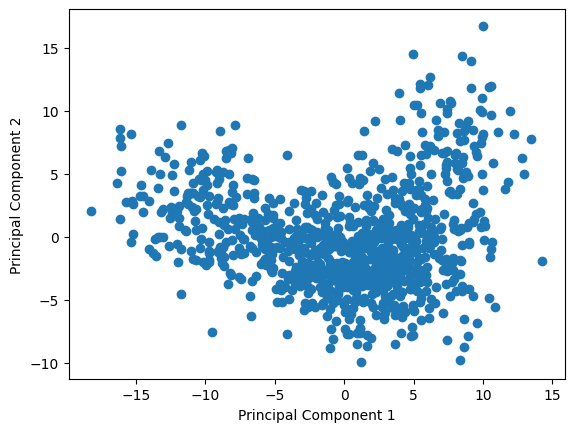

In [167]:
plt.scatter(x=pc1data, y=pc2data)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Looks like a lot of overlapping on the given axes so lot's of colinearity, its tough to pick a set of features to predict wins, especially because of how many there are. This is a perfect example of when to use Lasso Regularization! 

## Analysis, hypothesis testing, & ML

In this section we will create a Lasso Regression model that given the 19 stats from above will predict the number of wins a team will attain in the regular season. The coefficients that will be non-zero at the end will be the features the model has learned are the most important in predicting wins thereby answering our question from before. This is true because with Lasso Regularization the loss function is:
$$L(\theta) = \frac{1}{m}(\sum_{i=1}^m (h_{\theta}(x_i) - y_i)^2 + \lambda \sum_{j=1}^n|\theta_j|)$$
Then when taking the gradient notice that:
$$ \frac{\partial}{\partial \theta_i} \lambda \sum_{j=1}^n|\theta_j| = \frac{\partial}{\partial \theta_i} (\lambda |\theta_i|)$$
$$ = \theta_j > 0 \Rightarrow \lambda$$
$$ = \theta_j < 0 \Rightarrow -\lambda$$
This is by definition of the derivative of absolute value so
$$\nabla L(\theta) = \frac{1}{m}((h_{\theta}(x_i) - y_i) + \lambda \times sign(\theta)) $$

In [431]:
# helpful wrapper for repeating params
class LassoRegression():
    
    def __init__(self, alpha, iters, lambda1):
        self.alpha = alpha
        self.iters = iters
        self.lambda1 = lambda1
    # gradient descent algo , 
    def grad_descent(self,X,y):
        m, n = X.shape
        theta = np.zeros(n)
        
        f = np.zeros(self.iters)
        # i is each epoch
        for i in range(self.iters):
            # loss function at every epoch
            f[i] = (np.linalg.norm(X.dot(theta)-y)**2 + self.lambda1 * np.sum(np.abs(theta)))/m

            # compute gradient
            g = (np.transpose(X).dot(X.dot(theta) - y) + self.lambda1 * np.sign(theta))/m

            # adjust weights
            theta = theta - self.alpha*g
            

        return(theta,f)

Ensure normalized dataset for Lasso Regularization.

In [432]:
newX = Xn.copy()
newX = sm.add_constant(newX)
# make sure X is normalized has a constant term and is 
newX =  newX.to_numpy()
newX[:2]

array([[ 1.        ,  3.81361623,  6.05531453, -0.90055574, -0.98535248,
        -0.72758282, -2.86741178,  3.96101207,  4.20842835, -0.98834679,
         1.17215568,  1.06891981,  0.25565325,  3.91359584, -0.01001996,
         3.17509173,  0.88176564,  2.61755437,  0.03348703,  1.0758015 ],
       [ 1.        ,  2.21751471,  1.60900221,  1.65151368, -1.11615982,
        -1.10376184, -0.60322711,  2.8165383 ,  2.13059361,  0.63363003,
         3.76076218,  3.23968438,  0.91494914,  1.1101979 , -1.17198113,
        -0.40986897,  0.57475488,  2.0071576 , -0.42745206,  1.38317336]])

Learning rate of 0.01 and L1 penalty or lambda of 500 for 1000 epochs.

In [433]:
# train the Lasso Regression model defined above with a learning rate of 0.01, for 1000 iterations, and for an L1 penalty of 50
iter = 1000
lasso1 = LassoRegression(0.01, iter, 50)
(theta1, loss1) = lasso1.grad_descent(newX, y)
loss1[-5:]

array([43.57705082, 43.57546413, 43.57388254, 43.57230604, 43.5707346 ])

In [434]:
theta1

array([39.84870698, -1.39511323, -6.54976803,  5.4460298 , -0.49849103,
       -1.5010102 ,  2.42830934, -0.21847637, -1.18634508,  1.55190899,
        0.50139784,  0.14790922,  0.79938157,  2.78775804,  2.23212548,
        5.21889875,  1.10772112,  4.05200283,  0.34211463, -5.70750489])

Text(0, 0.5, 'Loss (MSE)')

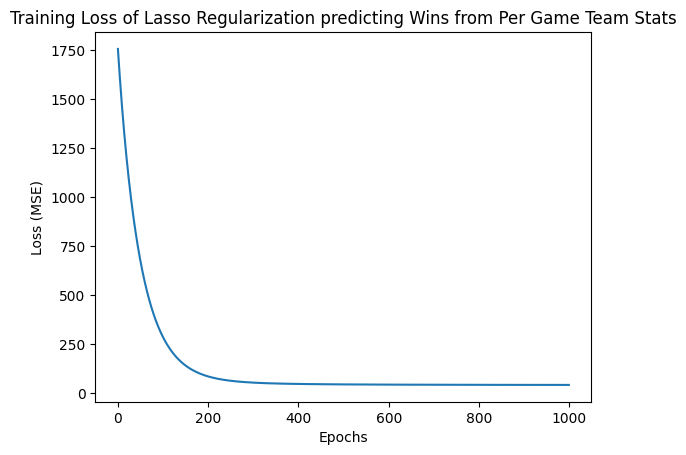

In [435]:
plt.plot(np.arange(iter), loss1)
plt.title("Training Loss of Lasso Regularization predicting Wins from Per Game Team Stats")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")

In [447]:
# create a dictionary for which the key is the feature name and the value is the theta value the lasso regularization model learned
# note the first theta value is the constant term
association = dict(zip(X.columns, theta1))
# then sort this dictionary in ascending order by the theta value
association = {k: v for k, v in sorted(association.items(), key=lambda item: -item[1])}
association

{'const': 39.848706981063295,
 'FG%': 5.446029802624948,
 'TRB': 5.218898752245358,
 'STL': 4.0520028305700535,
 'ORB': 2.7877580396855417,
 '3P%': 2.42830934176262,
 'DRB': 2.2321254811962747,
 '2P%': 1.551908994014645,
 'AST': 1.107721118975514,
 'FT%': 0.7993815656148143,
 'FT': 0.5013978424643797,
 'BLK': 0.34211462851295843,
 'FTA': 0.14790922347844973,
 '2P': -0.21847636529704664,
 '3P': -0.49849102880819235,
 '2PA': -1.1863450755036966,
 'FG': -1.395113230590178,
 '3PA': -1.5010101954859465,
 'TOV': -5.707504894219209,
 'FGA': -6.549768030445553}

From this first training round we can see that the model determined Field Goal Percentage has the highest importance, followed by Total Rebounds, then by Steals, then by Offensive Rebounds, then 3 Point Percentage, then by Defensive Rebounds, then 2 Point Percentage, then Assists, and so on. Interestingly the model learned an inverse relationship with 3 Pointers and wins. This is an odd outcome because it goes against our previous intution that 3 Pointers are important to winning due to thee current 3 Point Era of Basketball. Maybe this is because older Eras are included in the dataset Except for that the model seems to follow our intution well, that 3-Pointers are important to win. However we need to validate this model by testing it. Let's do a k-fold validation with *k =5*. 

In [437]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
# create arrays to store train  and test results
train_results = []
test_results = []
# convert y to an numpy array to use with sklearn
newy = np.array(y)
# for each fold generate train test split for x and y
for train, test in kf.split(newX):
    X_train, X_test, y_train, y_test = newX[train], newX[test], newy[train], newy[test]
    # train lasso model
    (theta, loss) = lasso1.grad_descent(X_train, y_train)
    # append the train results
    train_results.append((theta, loss))
    testMSE = (1/len(y_train))*np.linalg.norm(X_test.dot(theta) - y_test)**2
    # append the test MSE for the particular fold
    test_results.append((theta, testMSE))

Text(0.5, 1.0, 'Training Loss over Epochs for k=5 fold validation predicting Regular Season Wins')

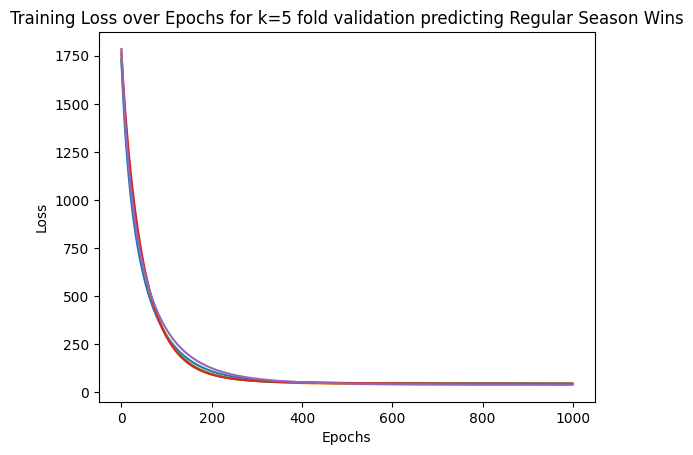

In [438]:
# plot the training loss over epoch for each fold
for (theta, loss) in train_results:
    plt.plot(np.arange(iter),loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
plt.title("Training Loss over Epochs for k=5 fold validation predicting Regular Season Wins")

In [439]:
# for each test result
for (i, (theta, testMSE)) in enumerate(test_results):
    # find the association in descending sorted order
    assoc = dict(zip(X.columns, theta1))
    assoc = {k: v for k, v in sorted(assoc.items(), key=lambda item: item[1])}
    # print the association with the fold number and the test MSE
    print( f"For fold {i} the test MSE was {testMSE} with an association of \t{list(reversed(assoc.keys()))}")

For fold 0 the test MSE was 16.990150622963395 with an association of 	['FG%', 'TRB', 'STL', 'ORB', '3P%', 'DRB', '2P%', 'AST', 'FT%', 'FT', 'BLK', 'FTA', '2P', '3P', '2PA', 'FG', '3PA', 'TOV', 'FGA']
For fold 1 the test MSE was 15.669204722584992 with an association of 	['FG%', 'TRB', 'STL', 'ORB', '3P%', 'DRB', '2P%', 'AST', 'FT%', 'FT', 'BLK', 'FTA', '2P', '3P', '2PA', 'FG', '3PA', 'TOV', 'FGA']
For fold 2 the test MSE was 9.2514463045605 with an association of 	['FG%', 'TRB', 'STL', 'ORB', '3P%', 'DRB', '2P%', 'AST', 'FT%', 'FT', 'BLK', 'FTA', '2P', '3P', '2PA', 'FG', '3PA', 'TOV', 'FGA']
For fold 3 the test MSE was 9.23146684341797 with an association of 	['FG%', 'TRB', 'STL', 'ORB', '3P%', 'DRB', '2P%', 'AST', 'FT%', 'FT', 'BLK', 'FTA', '2P', '3P', '2PA', 'FG', '3PA', 'TOV', 'FGA']
For fold 4 the test MSE was 30.192801920534798 with an association of 	['FG%', 'TRB', 'STL', 'ORB', '3P%', 'DRB', '2P%', 'AST', 'FT%', 'FT', 'BLK', 'FTA', '2P', '3P', '2PA', 'FG', '3PA', 'TOV', 'FGA']


From this we can conclude that our results above weren't a fluke. The model actually consistenly ranks the importance of the features the same. The test mean squared error does vary drastically maybe due to the size of our dataset being small. The test MSE doesn't seem to be too bad as if we take the square root of each then on average we have a residual of around 3 to 5 games. Since there are 80 games in a season this is a very small margin of error and accounts for the unpredictability or noise of a team's real performance during a season such as injuries. So we can safely conclude that the most important statistics to win are in order

FG, 3P, AST, BLK, DRB, 2P, TRB, FT, STL, ORB, FTA, TOV, FT%, 2PA, 3PA, 2P%, FGA, 3P%, FG%


Does this change for playoff wins?

For playoffs the following is important ['FG%', 'TRB', 'STL', 'ORB', '3P%', 'DRB', '2P%', 'AST', 'FT%', 'FT', 'BLK', 'FTA', '2P', '3P', '2PA', 'FG', '3PA', 'TOV', 'FGA']


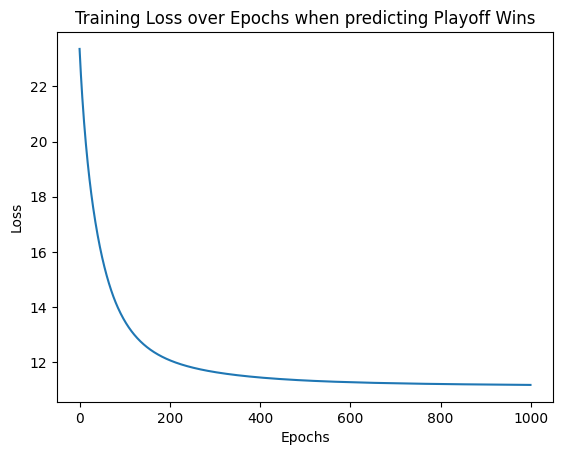

In [440]:
# create new label set from playoff wins column
playoff_y = main_df["playoff_wins"].to_numpy()
# train
(theta, loss) = lasso1.grad_descent(newX, playoff_y)
# plot training loss
plt.plot(np.arange(iter),loss)
plt.title("Training Loss over Epochs when predicting Playoff Wins")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# find the theta value for each feature then sort in descending order by the theta value
a = dict(zip(Xn.columns, theta1[1:]))
a = {k: v for k, v in sorted(a.items(), key=lambda item: item[1])}
print(f"For playoffs the following is important {list(reversed(a.keys()))}")

No it is the exact same.